# How to run the examples on Dataflow

This notebook illustrates a pipeline to stream the raw data from pub/sub to bigquery using dataflow runner and interactive runner .

This pipeline processes the raw data from pub/sub and loads into Bigquery and in parallel it also windows the raw data (using fixed windowing) for every 3 seconds and calculates the mean of sensor values on the windowed data


Note that running this example incurs a small [charge](https://cloud.google.com/dataflow/pricing) from Dataflow.

Let's make sure the Dataflow API is enabled. This [allows](https://cloud.google.com/apis/docs/getting-started#enabling_apis) your project to access the Dataflow service:


In [ ]:
!gcloud services enable dataflow

### 1. Start with necessary imports


In [117]:
import re
import json
from datetime import datetime
import apache_beam as beam
import random
import time
from google.cloud import pubsub_v1,bigquery
from apache_beam.options import pipeline_options
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.runners import DataflowRunner
from apache_beam.runners.interactive import interactive_runner
from apache_beam import DoFn, GroupByKey, io, ParDo, Pipeline, PTransform, WindowInto, WithKeys,Create,Map , CombineGlobally ,dataframe
import apache_beam.runners.interactive.interactive_beam as ib
import google.auth
import matplotlib.pyplot as plt

publisher  = pubsub_v1.PublisherClient() #Pubsub publisher client
subscriber = pubsub_v1.SubscriberClient() #Pubsub subscriber client
client     = bigquery.Client() #bigquery client

### 2. Set the variables . These variables will be referenced in later sections


In [42]:
dest_project=!gcloud config get-value project
project_id=dest_project[1]
print(project_id)

pubsub_topic                       = project_id + "-" + "topic" 
pubsub_subscription                = pubsub_topic + "-" + "sub"
pubsub_topic_path                  = publisher.topic_path(project_id, pubsub_topic)
pubsub_subscription_path           = subscriber.subscription_path(project_id, pubsub_subscription)

bq_dataset                         = "anomaly_detection_demo"
bigquery_agg_schema                = "sensorID:STRING,sensorValue:FLOAT,windowStart:DATETIME,windowEnd:DATETIME"
bigquery_raw_schema                = "sensorID:STRING,timeStamp:DATETIME,sensorValue:FLOAT"
bigquery_raw_table                 = bq_dataset + ".anomaly_raw_table" 
bigquery_agg_table                 = bq_dataset + ".anomaly_windowed_table" 
region                             = "us-central1"
bucket_name                        = project_id 

general-demo-364117


### 3: Create Pub/sub topic

In [ ]:
!gcloud pubsub topics create {pubsub_topic}

### 4: Create Pub/sub subscription

In [ ]:
!gcloud pubsub subscriptions create {pubsub_subscription} --topic={pubsub_topic}

### 5. Create BigQuery Dataset


In [ ]:
!bq --location={region} mk --dataset {project_id}:{bq_dataset}

### 6. Create BigQuery Tables

raw big query schema

![raw-schema](Images/raw-schema.png)

aggregated big query schema
![agg-schema](Images/agg-schema.png)

In [ ]:
!bq mk --schema {bigquery_raw_schema} -t {bigquery_raw_table}
!bq mk --schema {bigquery_agg_schema} -t {bigquery_agg_table}

### 7. Create GCS Bucket  

In [ ]:
!gsutil mb -c standard -l {region} gs://{bucket_name}

### 8. IMPORTANT! open GCS bucket from console and create a folder called dataflow.
path should be  gs://project_id/dataflow


### 9. set the pipeline options

In [41]:
# Setting up the Apache Beam pipeline options.
options = pipeline_options.PipelineOptions(flags={})

# Sets the pipeline mode to streaming, so we can stream the data from PubSub.
options.view_as(pipeline_options.StandardOptions).streaming = True

# Sets the project to the default project in your current Google Cloud environment.
_, options.view_as(GoogleCloudOptions).project = project_id

# Sets the Google Cloud Region in which Cloud Dataflow runs.
options.view_as(GoogleCloudOptions).region = region

### 10. create the function to format the raw data and processed data

In [57]:
# to add window begin datetime and endtime to the aggregated PCollections.
class FormatDoFn(beam.DoFn):
    def process(self, element, window=beam.DoFn.WindowParam):
        from datetime import datetime
        window_start = datetime.fromtimestamp(window.start)
        window_end = datetime.fromtimestamp(window.end)
        return [{
        'sensorID': element[0],
        'sensorValue': element[1],
        'windowStart': window_start,
        'windowEnd': window_end
        }]                     

In [50]:
# to get the raw PCollections
class ProcessDoFn(beam.DoFn):
    def process(self, element):
        yield element 

### 11. Construct the pipeline 
the pipeline from pub/sub topic and process the raw data to raw PCollections and process the aggregatesd windowed data to aggregated pcollections
the below pipeline reads the data from pub/topic and groups the data in 5 sec intervals and calculates the mean of sensor value for that window

![fixed-window](Images/fixed-window.png)

In [58]:
# Sets the Google Cloud Region in which Cloud Dataflow runs.
p = beam.Pipeline(interactive_runner.InteractiveRunner(), options=options)

# Sets the Google Cloud Region in which Cloud Dataflow runs.
mapped   = (p  | "ReadFromPubSub" >> beam.io.gcp.pubsub.ReadFromPubSub(subscription=pubsub_subscription_path)
               | "Json Loads" >> Map(json.loads))

# Sets the Google Cloud Region in which Cloud Dataflow runs.
raw_data = (mapped 
               | 'Format' >> beam.ParDo(ProcessDoFn()))

# Sets the Google Cloud Region in which Cloud Dataflow runs.            
agg_data = (mapped 
               | "Map Keys" >> Map(lambda x: (x["SensorID"],x["SensorValue"]))
               | "ApplyFixedWindow" >> beam.WindowInto(beam.window.FixedWindows(5))
               | "Total Per Key" >> beam.combiners.Mean.PerKey()
               | 'Final Format' >> beam.ParDo(FormatDoFn()))                        

Note that the `Pipeline` is constructed by an `InteractiveRunner`, so you can use operations such as `ib.collect` or `ib.show`.

In [ ]:
ib.show(agg_data)

ERROR:apache_beam.runners.direct.executor:Exception at bundle <apache_beam.runners.direct.bundle_factory._Bundle object at 0x7fd322af11c0>, due to an exception.
 Traceback (most recent call last):
  File "/jupyter/.kernels/apache-beam-2.45.0/packages/beam/sdks/python/apache_beam/runners/direct/executor.py", line 370, in call
    self.attempt_call(
  File "/jupyter/.kernels/apache-beam-2.45.0/packages/beam/sdks/python/apache_beam/runners/direct/executor.py", line 413, in attempt_call
    evaluator.process_element(value)
  File "/jupyter/.kernels/apache-beam-2.45.0/packages/beam/sdks/python/apache_beam/runners/direct/transform_evaluator.py", line 544, in process_element
    events.append(next(self.event_stream))
  File "/jupyter/.kernels/apache-beam-2.45.0/packages/beam/sdks/python/apache_beam/runners/direct/test_stream_impl.py", line 337, in events_from_rpc
    raise e
  File "/jupyter/.kernels/apache-beam-2.45.0/packages/beam/sdks/python/apache_beam/runners/direct/test_stream_impl.py",

### Dataflow Additions

Now, for something a bit different. Because Dataflow executes in the cloud, you need to output to a cloud sink. In this case, you are loading the transformed data into Cloud Storage.

First, set up the `PipelineOptions` to specify to the Dataflow service the Google Cloud project, the region to run the Dataflow Job, and the SDK location.

In [52]:
# IMPORTANT! Adjust the following to choose a Cloud Storage location.
dataflow_gcs_location = "gs://<replace project id with your projectID>/dataflow"

# Dataflow Staging Location. This location is used to stage the Dataflow Pipeline and SDK binary.
# options.view_as(GoogleCloudOptions).staging_location = dataflow_gcs_location

# Sets the project to the default project in your current Google Cloud environment.
_, options.view_as(GoogleCloudOptions).project = google.auth.default()

# Dataflow Temp Location. This location is used to store temporary files or intermediate results before finally outputting to the sink.
options.view_as(GoogleCloudOptions).temp_location = '%s/temp' % dataflow_gcs_location

# Dataflow job name. when pipeline runs as dataflowrunner.
options.view_as(GoogleCloudOptions).job_name = project_id


In [53]:
# Specifying the bigquery table to write `add_data` to,
# based on the `bigquery_raw_table` variable set earlier.
(raw_data | 'Write raw data to Bigquery' 
 >> beam.io.WriteToBigQuery(
                bigquery_raw_table,
                write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND))
# Specifying the bigquery table to write `add_data` to,
# based on the `bigquery_agg_table` variable set earlier.
(agg_data | 'Write windowed aggregated data to Bigquery' 
 >> beam.io.WriteToBigQuery(
                bigquery_agg_table,
                write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND))

In [54]:
# IMPORTANT! Ensure that the graph is correct before sending it out to Dataflow.
# Because this is a notebook environment, unintended additions to the graph may have occurred when rerunning cells. 
ib.show_graph(p)

/usr/bin/dot


### Running the pipeline

Now you are ready to run the pipeline on Dataflow. `run_pipeline()` runs the pipeline and return a pipeline result object.

In [55]:
pipeline_result = DataflowRunner().run_pipeline(p, options=options)

Using the `pipeline_result` handle, the following code builds a link to the Google Cloud Console web page that shows you details of the Dataflow job you just started:

In [56]:
from IPython.core.display import display, HTML
url = ('https://console.cloud.google.com/dataflow/jobs/%s/%s?project=%s' % 
      (pipeline_result._job.location, pipeline_result._job.id, pipeline_result._job.projectId))
display(HTML('Click <a href="%s" target="_new">here</a> for the details of your Dataflow job!' % url))


/tmp/ipykernel_4269/2966784630.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


dtaflow job
![dataflow-job](Images/DataflowJob.png)

### Important --Run simulator script in a sepate note book
PythonSimulator.ipynb
 

### Checking the raw table results
raw table results
![raw-table-results](Images/raw-data-results.png)

In [70]:
#check the raw data in BQ raw Table
sql = 'SELECT * FROM `{}` '.format(bigquery_raw_table)
query_job = client.query(sql)  # API request
raw_df = query_job.to_dataframe()
df

,sensorID,timeStamp,sensorValue
0,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 08:05:19.670,185.293134
1,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 08:06:11.049,192.403757
2,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 08:05:17.554,244.201024
3,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 08:05:30.347,196.650851
4,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 08:05:16.547,111.116663
...,...,...,...
22426,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 09:37:18.974,171.316666
22427,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 09:37:19.075,146.568026
22428,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 09:37:19.075,146.568026
22429,75c18751-7a94-453e-86f5-67be2b0c8fd4,2023-03-12 09:37:19.478,103.486520


### Checking the agg table results
agg table results
![agg-table-results](Images/agg-data-results.png)

In [113]:
#check the agg data in BQ raw Table
sql = 'SELECT   sensorID , case when sensorValue >= 215 then "Anomaly" else "Normal" end as type, sensorValue,row_number() over (order by windowStart) as cycle FROM `{}` '.format(bigquery_agg_table)
query_job = client.query(sql)  # API request
agg_df = query_job.to_dataframe()
agg_df

,sensorID,type,sensorValue,cycle
0,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,197.638890,1
1,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,213.066811,2
2,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,161.423363,3
3,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,176.782776,4
4,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,168.834653,5
...,...,...,...,...
114,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,213.135195,115
115,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,185.767645,116
116,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,206.109261,117
117,75c18751-7a94-453e-86f5-67be2b0c8fd4,Normal,159.763575,118


### Plot the results in a simple scatterplot chart 

Chart will display Anomalies in red color and Normal in Green color
![plot](Images/plot.png)

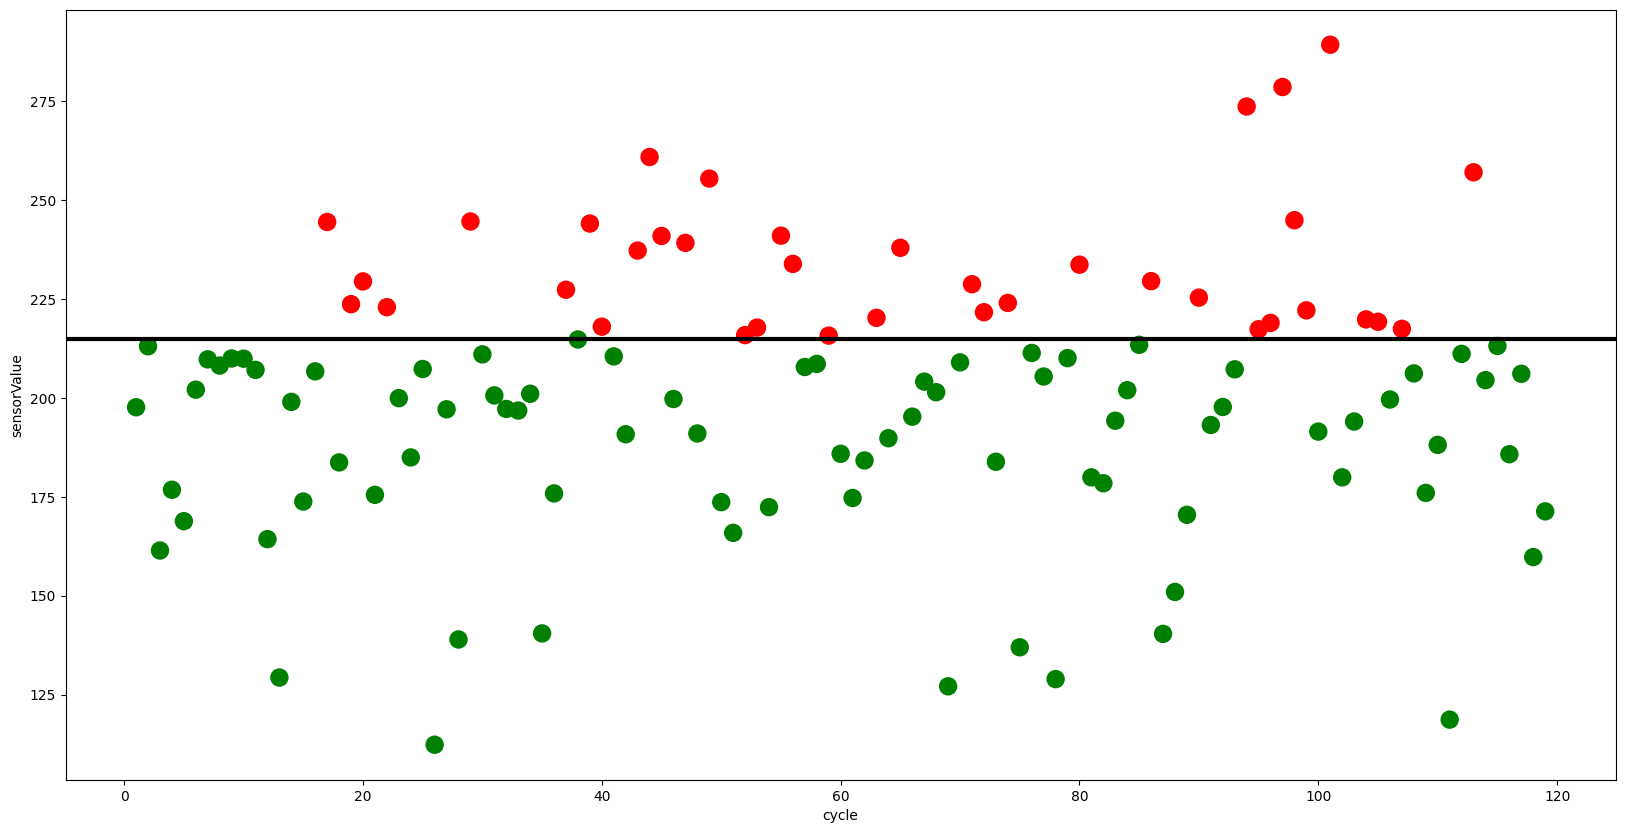

In [126]:
c=['green' if g=='Normal' else 'red' for g in agg_df['type']]
agg_df.plot(
    kind="scatter",
    x="cycle",
    y="sensorValue"  , c = c, s = 150,
    figsize=(20, 10)    
    )
plt.axhline(y=215, color='black', linestyle='-',linewidth=3)


# Congratulations!!!
End of lab
